In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

1) Log file is loaded

In [2]:
file = open("log.txt", "r") 
lines = file.readlines()
for l in range(3): print(lines[l][:-1])

156.15.13.173 [01/Jan/2018:11:13:49 +0100] "GET AddProduct.html HTTP/1.0" 200 2356
176.247.135.49 [01/Jan/2018:11:18:07 +0100] "GET Shop.html HTTP/1.0" 200 7466
176.247.135.49 [01/Jan/2018:11:19:05 +0100] "GET AddProduct.html HTTP/1.0" 200 2356


2) Cass "Request" parses and keeps data of a single requests. Complete the TODO, where a given "line" (string) should be parsed in order to dervie the ip of the host making the request, time of the request (in seconds), and target page (name).

In [3]:
class Request:
    def __init__(self, line):
        splitedLine = line.split(" ")
        
        self.ip = splitedLine[0]
        h = int(splitedLine[1].split(":")[1])
        m = int(splitedLine[1].split(":")[2])
        s = int(splitedLine[1].split(":")[3])
        self.time = h * 3600 + m * 60 + s
        self.page = splitedLine[4]
        
    def __repr__(self):
        return self.ip + "     " +  str(datetime.timedelta(seconds=self.time)) + " -> " + self.page


3) Each line of log.txt is parsed and the Request objects are added to the list

In [4]:
reqs = [Request(line) for line in lines]
for l in range(10): print(reqs[l]) 

156.15.13.173     11:13:49 -> AddProduct.html
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
57.116.45.120     11:46:45 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
26.19.183.202     11:53:11 -> AddProduct.html


# Exercise

Your task is to analyze the log file. You should indentify the users and sessions. Then, compute the following: <br>
3.1) the number of sessions (should be 1000 :) ), <br>
3.2) the number of users, <br>
3.3) the average number of sessions per one user <br>
3.4) use the distribution plot to visualize the sessions' lengths (minutes);  <br>
3.5) use the distribution plot to visualize the sessions' lengths (the number of requests) <br>
3.6) use the distribution plot to visualize sessions' starting times (hours). <br>
3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page,  <br>
3.8) which web page is the most common departure point?; for each page plot the number of times the user stopped a session while being on this page, <br>
3.9) for each page plot the average time the user stayed on this page <br>
3.10) print the fist 10 sessions (paths). <br>

You may find the following classes helpful and data.

In [5]:
class Session:
    def __init__(self):
        self.startTime = 0
        self.stopTime = 0
        self.requests = []
        
    def __init__(self, req):
        self.startTime = req.time
        self.stopTime = 0
        self.requests = [req]
        
    def __repr__(self):
        print("SESSION")
        print(self.startTime)
        print(self.stopTime)
        STR = ""
        for r in self.requests:
            print(r)
            STR += ("  " + r.page + "    " + str(datetime.timedelta(seconds=r.time)) + "\n")
        return STR

class Computer:
    def __init__(self):
        self.ip = []
        self.sessions = []
    def __init__(self, session):
        self.ip = session.requests[0].ip
        self.sessions = [session]
    def __repr__(self):
        return self.ip

PAGES = ["Shop.html", "AddProduct.html", "Summary.html", "Payment.html","About.html", "Contact.html"]

LINKS = [[1, 4],
         [2,4],
         [3],
         [],
         [1,5],
         []]

def processRequestsIntoComputersAndSessions(sessionDurationTreshold, singlePageSpentTimeTreshold):
    computers = {}
    for request in reqs:
        if request.ip not in computers:
            session = Session(request)
            session.stopTime = request.time + singlePageSpentTimeTreshold
            computer = Computer(session)
            computers[request.ip] = computer
            continue


        computer = computers[request.ip]
        
        timeFromSessionStart = request.time - computer.sessions[-1].startTime
        lastPageSpentTime = request.time - computer.sessions[-1].requests[-1].time
        
        isSessionDurationAcceptable = timeFromSessionStart <= sessionDurationTreshold
        isLastPageSpentTimeAcceptable = lastPageSpentTime <= singlePageSpentTimeTreshold
        isRequestPageInSessionPages = request.page in [req.page for req in computer.sessions[-1].requests]
        isRequestedPageLinked = PAGES.index(request.page) in \
                LINKS[PAGES.index(computers[request.ip].sessions[-1].requests[-1].page)]
        isRequestedPageAcceptable = isRequestPageInSessionPages or isRequestedPageLinked

        if isSessionDurationAcceptable and isLastPageSpentTimeAcceptable and isRequestedPageAcceptable:
            computer.sessions[-1].requests.append(request)
            computer.sessions[-1].stopTime = min(
                    request.time + singlePageSpentTimeTreshold, 
                    computer.sessions[-1].startTime + sessionDurationTreshold)
            continue


        #new session
        session = Session(request)
        session.stopTime = request.time + singlePageSpentTimeTreshold
        computer.sessions.append(session)
    return computers

sessionTreshold = 2500
pageTreshold = 800
computers = processRequestsIntoComputersAndSessions(sessionTreshold, pageTreshold)

#plot distribution
#count, bins, ignored = plt.hist(data, 50, alpha=0.5, normed=True)
#plt.plot()

#x_axis = np.arange(len(pages))
#plt.bar(x_axis, data, align='center', alpha=0.5)
#plt.xticks(y_pos, pages, rotation=90)

In [6]:
#1
sessionsCount = sum([len(computer.sessions) for computer in computers.values()])
print(sessionsCount)

1000


In [7]:
#2
usersCount = len(computers)
print(usersCount)

391


In [8]:
#3
avgSessionsPerUser = sessionsCount / usersCount
print(avgSessionsPerUser)

2.557544757033248


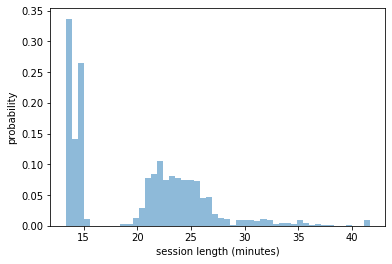

In [9]:
#4
sessionsLengths = []
for computer in computers.values():
    for session in computer.sessions:
        sessionsLengths.append((session.stopTime - session.startTime)/60)

plt.xlabel("session length (minutes)")
plt.ylabel("probability")
count, bins, ignored = plt.hist(sessionsLengths, 50, alpha=0.5, density=True)
plt.show()

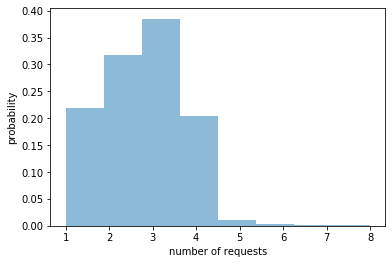

In [10]:
#5
sessionsRequestsCount = []
for computer in computers.values():
    for session in computer.sessions:
        sessionsRequestsCount.append(len(session.requests))

plt.xlabel("number of requests")
plt.ylabel("probability")
count, bins, ignored = plt.hist(sessionsRequestsCount, len(set(sessionsRequestsCount)), alpha=0.5, density=True)
plt.show()

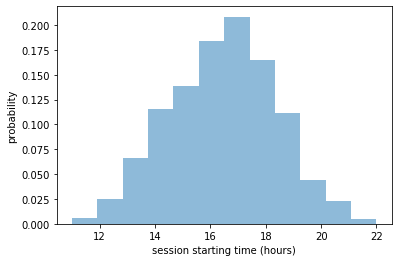

In [11]:
#6
sessionsStartingHours = []
for computer in computers.values():
    for session in computer.sessions:
        sessionsStartingHours.append(session.startTime // 3600)

plt.xlabel("session starting time (hours)")
plt.ylabel("probability")
count, bins, ignored = plt.hist(sessionsStartingHours, len(set(sessionsStartingHours)), alpha=0.5, density=True)
plt.show()

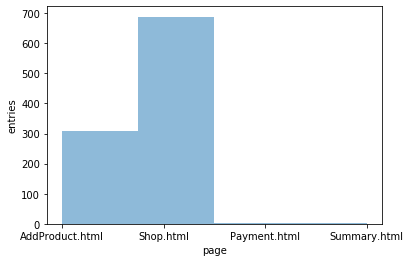

In [12]:
#7
entryPages = []
for computer in computers.values():
    for session in computer.sessions:
        entryPages.append(session.requests[0].page)

plt.xlabel("page")
plt.ylabel("entries")
count, bins, ignored = plt.hist(entryPages, len(set(entryPages)), alpha=0.5)
plt.show()

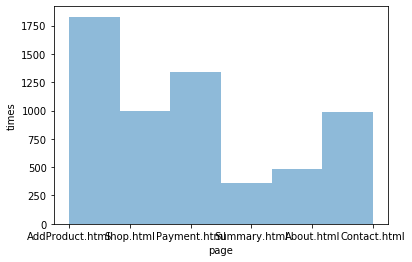

In [27]:
#8
departurePages = []
for computer in computers.values():
    for session in computer.sessions:
        entryPages.append(session.requests[-1].page)

plt.xlabel("page")
plt.ylabel("times")
count, bins, ignored = plt.hist(entryPages, len(set(entryPages)), alpha=0.5)
plt.show()

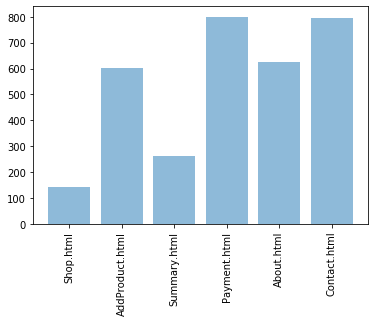

In [23]:
#9
pageSpentTimes = {}
for page in PAGES:
    pageSpentTimes[page] = []
    
for computer in computers.values():
    for session in computer.sessions:
        lastTime = 0
        for requestI, request in enumerate(session.requests):
            if requestI == len(session.requests) - 1:
                pageSpentTimes[request.page].append(pageTreshold)
                continue
            pageSpentTimes[request.page].append(session.requests[requestI + 1].time - request.time)
            
avgPageSpentTimes = {}
for page in pageSpentTimes:
    avgPageSpentTimes[page] = np.mean(pageSpentTimes[page])

x_axis = np.arange(len(PAGES))
plt.bar(PAGES, avgPageSpentTimes.values(), align='center', alpha=0.5)
plt.xticks(rotation=90)
plt.show()

In [33]:
#10
allSesions = []
for computer in computers.values():
    allSesions.extend(computer.sessions)
allSesions.sort(key=lambda session: session.startTime)
first10Sessions = allSesions[:10]
print(first10Sessions)


SESSION
40429
41229
156.15.13.173     11:13:49 -> AddProduct.html
SESSION
40687
42145
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
SESSION
42239
43558
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
SESSION
42405
43727
57.116.45.120     11:46:45 -> AddProduct.html
57.116.45.120     11:53:25 -> Summary.html
57.116.45.120     11:55:27 -> Payment.html
SESSION
42791
44410
26.19.183.202     11:53:11 -> AddProduct.html
26.19.183.202     11:59:00 -> About.html
26.19.183.202     12:06:50 -> Contact.html
SESSION
43489
44374
76.75.209.209     12:04:49 -> Shop.html
76.75.209.209     12:06:14 -> AddProduct.html
SESSION
43765
44638
167.139.89.69     12:09:25 -> Shop.html
167.139.89.69     12:10:38 -> About.html
SESSION
43837
45298
30.60.2.154     12:10:37 -> Shop.html
30.60.2.154     12:12:01 ->